# FluidAINet

In [1]:
import os
import time

import numpy as np
import pandas as pd
import tensorflow as tf

## Crazy Accelaration - same y?

In [25]:

x = tf.placeholder(tf.float32, shape=(None,64,12), name='x')
x1 = x[:,:,i*3:i*3+3]

In [43]:
with open('test.txt','a') as f:
    f.write(str([1,2 ,3]))

In [26]:
x1

<tf.Tensor 'strided_slice_1:0' shape=(?, 64, 3) dtype=float32>

In [45]:
%run -i predict.py

In [46]:
%run -i utils/model_utils.py

sync


In [47]:
%run -i utils/fluid_loader.py

In [49]:
from config import cfg
dataset_dir = cfg.DATA_DIR
train_dir = os.path.join(cfg.DATA_DIR, 'train')
avail_gpus = cfg.GPU_AVAILABLE.split(',')
info_project = cfg.INFO_DIR_PROJECT

Tensor("ScatterNd:0", shape=(25, 40, 40, 50, 128), dtype=float32)
[<tf.Tensor 'gpu_0/MiddleAndReg_/output/BiasAdd_1:0' shape=(?, 3) dtype=float32>]
Tensor("concat_25:0", shape=(?, 64, 14), dtype=float32)
csv


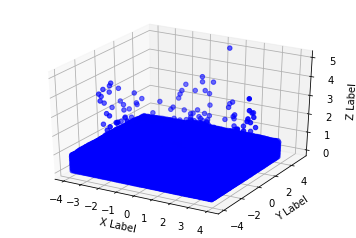

In [50]:
zero_time = get_local_time()
init_batch_size = 25
forward_step = 3
# load trained model
model_dir = "/data/info/FluidAiNet/save_model/default"
frozen_model_filename = os.path.join(model_dir, "../frozen_model/frozen_model.pb")
predict = Predict(frozen_model_filename, batch_size=init_batch_size)

# create dir for current task
# os.makedirs(path) multifolders os.mkdir(path) singlefolder
localtime = time.asctime(time.localtime(time.time()))
unique_dir = '_'.join(str(localtime).split(' '))

forward_dir = os.path.join(info_project, unique_dir)
if not os.path.exists(forward_dir):
    os.mkdir(forward_dir)
acc_dir = os.path.join(forward_dir, 'acc')
if not os.path.exists(acc_dir):
    os.mkdir(acc_dir)
figure_dir = os.path.join(forward_dir, 'figure')
if not os.path.exists(figure_dir):
    os.mkdir(figure_dir)

# load init data
TRAIN_FILES = get_all_frames(train_dir)
file_path = list(TRAIN_FILES)[0]
data, label, index = load_data_label(file_path, isvalues=False)
figure_path = os.path.join(figure_dir, 'figure_0.png')
plot_3d_scater_df(data[index[0]:index[-1]], 0, figure_path)

delta_t = 0.000608

start = time.clock()

result = []



In [52]:
for batch, batch_size in iterate_single_frame(train_dir, file_path, data_new=None, index_new=None, sample_rate=1,
                                              batch_size=25):
    if batch_size != init_batch_size:
        predict = Predict(frozen_model_filename, batch_size=batch_size)
    accelaration_eval = predict.fluidnet_predict(batch_size=batch_size, singel_batch=batch)
    print('**********', accelaration_eval)
#     write_acc_2_file(f, accelaration_eval)
    result.extend(accelaration_eval)
    break

csv
0  of  2474
concat feature:
 0.5643890000001193
accelaration_eval:
 1.6654889999999796
********** [[ 0.12222901 -0.04465033  0.16598418]
 [ 0.12222901 -0.04465033  0.16598418]
 [ 0.12222901 -0.04465033  0.16598418]
 [ 0.12222901 -0.04465033  0.16598418]
 [ 0.12222901 -0.04465033  0.16598418]
 [ 0.12222901 -0.04465033  0.16598418]
 [ 0.12222901 -0.04465033  0.16598418]
 [ 0.12222901 -0.04465033  0.16598418]
 [ 0.12222901 -0.04465033  0.16598418]
 [ 0.12222901 -0.04465033  0.16598418]
 [ 0.12222901 -0.04465033  0.16598418]
 [ 0.12222901 -0.04465033  0.16598418]
 [ 0.12222901 -0.04465033  0.16598418]
 [ 0.12222901 -0.04465033  0.16598418]
 [ 0.12222901 -0.04465033  0.16598418]
 [ 0.12222901 -0.04465033  0.16598418]
 [ 0.12222901 -0.04465033  0.16598418]
 [ 0.12222901 -0.04465033  0.16598418]
 [ 0.12222901 -0.04465033  0.16598418]
 [ 0.12222901 -0.04465033  0.16598418]
 [ 0.12222901 -0.04465033  0.16598418]
 [ 0.12222901 -0.04465033  0.16598418]
 [ 0.12222901 -0.04465033  0.16598418]
 

## LoadData

In [28]:
%run -i utils/fluid_loader.py

['/data/datasets/simulation_data/water/test/1', '/data/datasets/simulation_data/water/test/0']


In [8]:
def iter_data():
    yield 3,4
    


3 4


In [10]:
%run -i utils/preprocess.py

In [12]:
# %run -i utils/model_utils.py

In [13]:
# %run -i model/rpn.py

In [7]:
%run -i predict.py

In [5]:
def plot_3d_scater_df(particles_df, is_solid, figure_path):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    cols = particles_df.columns
    particles_df = particles_df[particles_df[cols[6]] == is_solid]
    x = particles_df[cols[0]]
    y = particles_df[cols[1]]
    z = particles_df[cols[2]]
    ax.scatter(x, y, z, c="b", marker='o')

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.savefig(figure_path)
    plt.show()

In [38]:
train_dir = '/data/datasets/simulation_data/water'
train_dir = os.path.join(train_dir, 'train')
TRAIN_FILES = list(get_all_frames(train_dir))


In [41]:
np.random.shuffle(TRAIN_FILES)
TRAIN_FILES[0:5]

['/data/datasets/simulation_data/water/train/8/all_particles_1365.csv',
 '/data/datasets/simulation_data/water/train/8/all_particles_907.csv',
 '/data/datasets/simulation_data/water/train/8/all_particles_3817.csv',
 '/data/datasets/simulation_data/water/train/7/all_particles_4268.csv',
 '/data/datasets/simulation_data/water/train/8/all_particles_1870.csv']

In [26]:
%matplotlib inline
train_dir = '/data/datasets/simulation_data/water'
train_dir = os.path.join(train_dir, 'train')
TRAIN_FILES = get_all_frames(train_dir)
file_path = list(TRAIN_FILES)[0]
print(file_path)
data, label, index = load_data_label(file_path, isvalues=False)
print(type(data))
delta_t = 0.000608
# plot_3d_scater_df(data, 0, 'figure.png')

/data/datasets/simulation_data/water/train/3/particles_665.csv
csv
<class 'pandas.core.frame.DataFrame'>


In [7]:
data.

,position_x,position_y,position_z,velocity_x,velocity_y,velocity_z,isFluidSolid,source
0,-2.26899,-2.26895,1.434160,-8.96105,-8.96081,8.13122,0.0,0.0
1,-1.41472,-1.92289,0.913243,-1.80043,-4.24813,5.05253,0.0,0.0
2,-1.30237,-2.05422,0.636501,-1.83795,-3.81244,3.52598,0.0,0.0
3,-1.05172,-2.29496,0.806513,-2.16775,-5.49689,4.61754,0.0,0.0
4,-0.88530,-2.28685,0.754451,-1.84459,-6.28127,4.85521,0.0,0.0


In [16]:
indices = np.arange(index.shape[0])
np.random.shuffle(indices)

In [18]:
np.random.shuffle(indices)
indices

array([ 8850, 11617, 18370, ..., 20987,  4013, 22553])

In [23]:
data.values[indices]

array([[-0.11988   ,  1.12778   ,  0.229662  , ..., -1.02663   ,
         0.        ,  0.        ],
       [-3.87792   , -3.87264   ,  0.122554  , ..., -0.00812684,
         0.        ,  0.        ],
       [-3.44288   ,  0.901068  ,  0.178248  , ...,  0.30391   ,
         0.        ,  0.        ],
       ..., 
       [ 3.58445   ,  2.60604   ,  0.0586877 , ...,  0.0895625 ,
         0.        ,  0.        ],
       [-1.38928   , -0.366507  ,  0.281424  , ..., -1.62108   ,
         0.        ,  0.        ],
       [ 2.50042   ,  3.75705   ,  0.0702138 , ...,  0.0382029 ,
         0.        ,  0.        ]])

In [7]:
acc_path = '/data/info/FluidAiNet/Tue_Jul__3_15:58:35_2018'
acc = os.path.join(acc_path, 'acc/accelaration_0.txt')


In [11]:
df_acc = laod_csv(acc)

In [9]:
accs.tail(5)

,2.40776e+08,3.46494e+08,-3.81205e+08
42665,657630000.0,885467000.0,-9.927660e+08
42666,657630000.0,885467000.0,-9.927660e+08
42667,704988000.0,945417000.0,-1.067040e+09
42668,704988000.0,945417000.0,-1.067040e+09
42669,635952000.0,853892000.0,-9.642340e+08


In [14]:
# updata velocity
# df_acc = pd.DataFrame(accelaration_eval)
cols = data.columns
for i in range(3):
    data[cols[i+3]][index[0]: index[-1]] = data[cols[i+3]][index[0]: index[-1]] + df_acc[df_acc.columns[i]]*delta_t


# update position
for i in range(3):
    data[cols[i]][index[0]: index[-1]] = data[cols[i]][index[0]: index[-1]] + data[cols[i+3]][index[0]: index[-1]]*delta_t

In [5]:
#i = 0
#data[cols[i+3]][index[0]: index[-1]]*delta_t

In [10]:
test_predict = True
if test_predict:

    batch_size = 25
    forward_step = 3
    # load trained model
    model_dir = "/data/info/FluidAiNet/save_model/default"
    frozen_model_filename = os.path.join(model_dir, "../frozen_model/frozen_model.pb")
    predict = Predict(frozen_model_filename, batch_size=batch_size)

    # create dir for current task
    # os.makedirs(path) multifolders os.mkdir(path) singlefolder
    localtime = time.asctime(time.localtime(time.time()))
    unique_dir = '_'.join(str(localtime).split(' '))

    forward_dir = os.path.join(info_project, unique_dir)
    if not os.path.exists(forward_dir):
        os.mkdir(forward_dir)
    acc_dir = os.path.join(forward_dir, 'acc')
    if not os.path.exists(acc_dir):
        os.mkdir(acc_dir)
    figure_dir = os.path.join(forward_dir, 'figure')
    if not os.path.exists(figure_dir):
        os.mkdir(figure_dir)

    # load init data
    TRAIN_FILES = get_all_frames(train_dir)
    file_path = list(TRAIN_FILES)[0]
    data, label, index = load_data_label(file_path, isvalues=False)
    figure_path = os.path.join(figure_dir, 'figure_0.png')
    plot_3d_scater_df(data[index[0]:index[-1]], 0, figure_path)

    delta_t = 0.000608

    start = time.clock()

    result = []

    for step in range(forward_step):
        f = open(os.path.join(acc_dir, 'accelaration_%d.txt' % step), 'w+')
        if step == 0:
            accelaration_eval = iter_batch_size(f, predict, result, start, train_dir, file_path, data_new=None, index_new=None,
                            batch_size=25)
        else:
            accelaration_eval = iter_batch_size(f, predict, result, start, train_dir, file_path, data_new=data, index_new=index,
                            batch_size=25)
        f.close()
        # todo update velocity and accrlaration
        figure_path = os.path.join(figure_dir, 'figure_%d.png' % (step+1))
        plot_3d_scater_df(data[index[0]:index[-1]], 0, figure_path)

Tensor("ScatterNd:0", shape=(25, 40, 40, 50, 128), dtype=float32)
[<tf.Tensor 'gpu_0/MiddleAndReg_/output/BiasAdd_1:0' shape=(?, 3) dtype=float32>]
[<tf.Tensor 'concat_25:0' shape=(?, 64, 14) dtype=float32>]
csv
csv
0  of  1707
concat feature:
 0.5945229999999952
accelaration_eval:
 0.7413200000000018
duration:
 3.9169919999999934
csv
0  of  1707
concat feature:
 0.5751069999999885
accelaration_eval:
 0.8558299999999974
duration:
 12.473003999999989
csv
0  of  1707
concat feature:
 0.46944400000000996
accelaration_eval:
 0.7185270000000088
duration:
 20.567613999999992


In [66]:
f = open('write_test.txt', 'w+')
for acc in accelaration_eval:  
    for num in acc:
        f.write(str(num))
        f.write(',')
    f.write('\n')
f.close()

In [15]:
df_acc = pd.DataFrame(accelaration_eval)

In [12]:
data, label, index
data[index[0]:index[24]] = data[index[0]:index[24]]

NameError: name 'fps' is not defined

array([ 24077646.,  34649440., -38120492.], dtype=float32)

In [57]:
list(accelaration_eval[0])[0]

2.4077645e+08

In [17]:
cols = data.columns

In [19]:
cols[0]

'position_x'

In [31]:
data


,position_x,position_y,position_z,velocity_x,velocity_y,velocity_z,isFluidSolid,source
0,88.006383,127.086496,-136.420905,146392.078125,210668.578125,-231772.803927,0.0,0.0
1,88.106383,127.086496,-136.420905,146392.078125,210668.578125,-231772.803927,0.0,0.0
2,83.632333,121.243578,-129.829045,138868.968750,201058.515625,-220930.928927,0.0,0.0
3,83.732333,121.243578,-129.829045,138868.968750,201058.515625,-220930.928927,0.0,0.0
4,94.581498,135.098985,-145.201726,156548.515625,223847.015625,-246214.944552,0.0,0.0
5,94.681498,135.098985,-145.201726,156548.515625,223847.015625,-246214.944552,0.0,0.0
6,87.296799,125.639342,-134.531887,144238.156250,208288.390625,-228665.866427,0.0,0.0
7,87.396799,125.639342,-134.531887,144238.156250,208288.390625,-228665.866427,0.0,0.0
8,112.238409,157.093756,-169.709038,184931.593750,260022.625000,-286523.022677,0.0,0.0
9,112.338409,157.093756,-169.709038,184931.593750,260022.625000,-286523.022677,0.0,0.0


In [4]:
batch_size = 25

In [6]:
singel_batch = None
for batch in iterate_data(train_dir, batch_size=batch_size):
    singel_batch = batch 
    break
    

csv


In [7]:
singel_batch[0].shape

(1, 25, 3)

In [8]:
"""
ret = (
    np.array(vox_labels),
    np.array(vox_feature),
    np.array(vox_number),
    np.array(vox_coordinate),
    np.array(vox_centroid),
    np.array(vox_k_dynamic)
)
"""
singel_batch[1].shape

(1, 58925, 64, 8)

保存目前的模型，并加载在新的graph中

In [9]:
# # freeze model
model_dir = "/data/deeplearning/FluidAiNet/save_model/default"
try:
    freeze_graph(model_dir, output_node_names="gpu_0/screen_size,concat_129,gpu_0/MiddleAndRPN_/output/BiasAdd")
except Exception as e:
    print("output_node_names not find in the graph:\n", e)

output_node_names not find in the graph:
 'NoneType' object has no attribute 'model_checkpoint_path'


In [9]:
# graph model file path
model_dir = "/data/deeplearning/FluidAiNet/save_model/default"
frozen_model_filename = os.path.join(model_dir, "../frozen_model/frozen_model.pb")

In [5]:
# load graph
# graph = load_graph(frozen_model_filename)
graph, acceleration = load_graph_with_input_map(frozen_model_filename, batch_size=batch_size)

Tensor("ScatterNd:0", shape=(25, 40, 40, 50, 128), dtype=float32)
[<tf.Tensor 'gpu_0/MiddleAndRPN_/output/BiasAdd_1:0' shape=(?, 3) dtype=float32>]


## Full Flow

In [15]:
"""
Full Flow
1. create new scatter_nd with new batch size
2. get graph and acceleration by load_graph_with_input_map
3. get tensor in graph by tensor name(pay a attention tensor should be in same graph)
4. load particles in a frame
"""
graph, acceleration = load_graph_with_input_map(frozen_model_filename, batch_size=batch_size)
"""
node name
"""
'gpu_0/feature_0'
'gpu_0/k_dynamics'
'gpu_0/centroid'
'gpu_0/coordinate'
screen_size = graph.get_tensor_by_name('gpu_0/screen_size:0')
feature = graph.get_tensor_by_name('gpu_0/feature:0')
part_feature = graph.get_tensor_by_name('gpu_0/part_feature:0')
concat_feature = graph.get_tensor_by_name('concat_129:0')
# accelaration = graph.get_tensor_by_name("gpu_0/MiddleAndRPN_/output/BiasAdd:0")
centroid = graph.get_tensor_by_name("gpu_0/centroid:0")
k_dynamics = graph.get_tensor_by_name("gpu_0/k_dynamics:0")
coordinate = graph.get_tensor_by_name("gpu_0/coordinate:0")
phase = graph.get_tensor_by_name("phase:0")
scatter_nd = graph.get_tensor_by_name('gpu_0/ScatterNd:0')
voxelwise = graph.get_tensor_by_name("gpu_0/Max_1:0")
# 需要feed新的变量
phase_1 = graph.get_tensor_by_name("phase_1:0")

"""
generate fake data with batch_size = 3
"""
def sample_Z_3D(m, n, k):
    return np.random.uniform(-8., 8., size=[m, n, k])
def sample_Z_2D(m, n):
    return np.random.uniform(-8., 8., size=[m, n])

feature_ = sample_Z_3D(7, 64, 8)
k_dynamics_ = np.array([4, 1, 2])
coordinate_ = np.array([[0, 1, 2, 3],
           [0, 1, 2, 3],
           [0, 1, 2, 3],
           [0, 1, 2, 3],
           [1, 1, 2, 3],
           [1, 1, 2, 3],
           [2, 1, 2, 3],  ])
centroid_ = np.array([[0.4, 0.4, 0.4], [0.3, 0.3, 0.3], [0.3, 0.3, 0.3]])
   
    


Tensor("ScatterNd:0", shape=(25, 40, 40, 50, 128), dtype=float32)
[<tf.Tensor 'gpu_0/MiddleAndRPN_/output/BiasAdd_1:0' shape=(?, 3) dtype=float32>]


In [16]:
def fluidnet_predict(graph, batch_size=1, singel_batch=None):
    
    
    # predict
    with tf.Session(graph=graph) as sess:
        input_dict = dict()
        input_dict[phase] = False
        input_dict[phase_1] = False
        screen_size_eval = screen_size.eval(session=sess, feed_dict={screen_size: batch_size})
        concat_feature_all = []
        count = 0
        # 如果要并行的话肯定还是要处理的，
        print("screen_size_eval:\n", screen_size_eval)
        for screen in range(screen_size_eval):
            k = k_dynamics[screen]
            concat_feature_all.append(tf.concat([part_feature[count: count+k],part_feature[count: count+k,:,:3] -centroid[screen]],axis=2))

            count += k
        concat_feature_all = tf.concat(concat_feature_all, axis=0)
        """
        what if I use fake data
        """
        option = 2
        if option == 2 and singel_batch is None:
            print("single_batch can't be None")
            return 
        if option == 1:
            input_dict[part_feature] = feature_
            input_dict[k_dynamics] = k_dynamics_
            input_dict[centroid] = centroid_
            concat_feature_eval = sess.run(concat_feature_all, input_dict)
            input_dict[feature] = concat_feature_eval
            input_dict[coordinate] = coordinate_
        #     input_dict[coordinate] = singel_batch[0]
            accelaration_eval = sess.run(acceleration[0], feed_dict=input_dict)
        else:
            input_dict[part_feature] = singel_batch[1][0]
            input_dict[k_dynamics] = singel_batch[5][0]
            input_dict[centroid] = singel_batch[4][0]
            concat_feature_eval = sess.run(concat_feature_all, input_dict)
            input_dict[feature] = concat_feature_eval
            input_dict[coordinate] = singel_batch[3][0]
            input_dict[phase] = False
        #     input_dict[coordinate] = singel_batch[0]
            accelaration_eval = sess.run(acceleration[0], feed_dict=input_dict)
            
        return accelaration_eval
 

In [ ]:
"""
frame to batch
"""
start = time.clock()
result = []
for batch in iterate_single_frame(train_dir, file_path, batch_size=batch_size):
    accelaration_eval = fluidnet_predict(graph, batch_size=batch_size, singel_batch=batch)
    result.append(accelaration_eval)
print('duration:\n', time.clock()-start)

csv
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen

screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_siz

screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_siz

Process ForkPoolWorker-11:
Process ForkPoolWorker-12:
Process ForkPoolWorker-13:
Traceback (most recent call last):
Process ForkPoolWorker-14:
  File "/home/f1001/.pyenv/versions/3.5.4/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/f1001/.pyenv/versions/3.5.4/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/f1001/.pyenv/versions/3.5.4/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/f1001/.pyenv/versions/3.5.4/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/f1001/.pyenv/versions/3.5.4/lib/python3.5/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/f1001/.pyenv/versions/3.5.4/lib/python3.5/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "

screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25
screen_size_eval:
 25


In [17]:
accelaration_eval = fluidnet_predict(graph, batch_size=batch_size, singel_batch=singel_batch)

screen_size_eval:
 25


In [18]:
accelaration_eval.shape

(25, 3)

In [20]:
result = []

In [22]:
result.extend(accelaration_eval)

[array([ -1.49290085,   0.13700485, -23.88957787], dtype=float32),
 array([ -1.49290085,   0.13700485, -23.88957787], dtype=float32),
 array([ -1.49021721,   0.14236933, -23.99931717], dtype=float32),
 array([ -1.49021721,   0.14236933, -23.99931717], dtype=float32),
 array([ -1.48733687,   0.14902812, -24.09713364], dtype=float32),
 array([ -1.48733687,   0.14902812, -24.09713364], dtype=float32),
 array([ -1.48436522,   0.15466624, -24.17471886], dtype=float32),
 array([ -1.48436522,   0.15466624, -24.17471886], dtype=float32),
 array([ -1.48328257,   0.15874499, -24.2313118 ], dtype=float32),
 array([ -1.48328257,   0.15874499, -24.2313118 ], dtype=float32),
 array([ -1.48043323,   0.16298372, -24.25707245], dtype=float32),
 array([ -1.48043323,   0.16298372, -24.25707245], dtype=float32),
 array([ -1.48060989,   0.16921085, -24.27262688], dtype=float32),
 array([ -1.48060989,   0.16921085, -24.27262688], dtype=float32),
 array([ -1.49104095,   0.17247421, -24.27692223], dtype=float

## Quick Test

In [88]:
prefix = ''
with tf.gfile.GFile(frozen_model_filename, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())

# Then, we import the graph_def into a new Graph and returns it
graph_out = graph
with tf.Graph().as_default() as graph:
    tf.import_graph_def(graph_def, name=prefix)
    coordinate = graph.get_tensor_by_name("gpu_0/coordinate:0")
    voxelwise = graph.get_tensor_by_name("gpu_0/Max_1:0")
    scatter_nd = graph.get_tensor_by_name("gpu_0/ScatterNd:0")
    # holder = tf.placeholder(tf.float32,shape=(3, 40, 40, 50, 1))
    new_scatter_nd = tf.scatter_nd(coordinate, voxelwise, shape=[batch_size, 40, 40, 50, 128])
    print(new_scatter_nd)
    conv3D = graph.get_tensor_by_name('gpu_0/MiddleAndRPN_/conv1/Conv3D:0')
    # print(conv3D)
    # conv3D.input = new_scatter_nd
    # print(conv3D.input.shape)
    # graph.graph_place()
    # The name var will prefix every op/nodes in your graph
    # Since we load everything in a new graph, this is not needed
#with tf.Graph().as_default() as graph:
    #scatter_nd = graph.get_tensor_by_name('gpu_0/ScatterNd:0')
    # saver = tf.train.import_meta_graph(graph_def, name=prefix, input_map={'gpu_0/ScatterNd': holder})
    #z = tf.import_graph_def(graph_def, name=prefix, input_map={'gpu_0/ScatterNd:0': new_scatter_nd},return_elements=["gpu_0/MiddleAndRPN_/conv1/Conv3D:0"])
    accerlation = tf.import_graph_def(graph_def, name=prefix, input_map={'gpu_0/ScatterNd:0': new_scatter_nd}, return_elements=["gpu_0/MiddleAndRPN_/conv3/Conv3D:0"])
    print(accerlation)
    graph_out = graph
    print(graph)

Tensor("ScatterNd:0", shape=(3, 40, 40, 50, 128), dtype=float32)
[<tf.Tensor 'gpu_0/MiddleAndRPN_/conv3/Conv3D_1:0' shape=(3, 40, 40, 12, 64) dtype=float32>]


In [29]:
import math
math.floor(9/2)

4

In [89]:
# graph_out.get_operations()

In [67]:
voxelwise

<tf.Tensor 'gpu_0/Max_1:0' shape=(?, 128) dtype=float32>

In [29]:
conv3d_1 = graph.get_tensor_by_name('gpu_0/MiddleAndRPN_/conv1/Conv3D:0')

In [30]:
conv3d_1

<tf.Tensor 'gpu_0/MiddleAndRPN_/conv1/Conv3D:0' shape=(4, 40, 40, 25, 64) dtype=float32>

In [7]:
# cheack nodes in gaph
with tf.Session(graph=graph) as sess:
#     sess.run(tf.global_variables_initializer())
    print(all_nodes(""))

['phase', 'gpu_0/part_feature', 'gpu_0/centroid', 'gpu_0/k_dynamics', 'gpu_0/screen_size', 'gpu_0/feature', 'gpu_0/coordinate', 'gpu_0/Max/reduction_indices', 'gpu_0/Max', 'gpu_0/NotEqual/y', 'gpu_0/NotEqual', 'VFE-1/kernel', 'VFE-1/kernel/read', 'VFE-1/bias', 'VFE-1/bias/read', 'gpu_0/VFE-1/Tensordot/Shape', 'gpu_0/VFE-1/Tensordot/Rank', 'gpu_0/VFE-1/Tensordot/axes', 'gpu_0/VFE-1/Tensordot/GreaterEqual/y', 'gpu_0/VFE-1/Tensordot/GreaterEqual', 'gpu_0/VFE-1/Tensordot/Cast', 'gpu_0/VFE-1/Tensordot/mul', 'gpu_0/VFE-1/Tensordot/Less/y', 'gpu_0/VFE-1/Tensordot/Less', 'gpu_0/VFE-1/Tensordot/Cast_1', 'gpu_0/VFE-1/Tensordot/add', 'gpu_0/VFE-1/Tensordot/mul_1', 'gpu_0/VFE-1/Tensordot/add_1', 'gpu_0/VFE-1/Tensordot/range/start', 'gpu_0/VFE-1/Tensordot/range/delta', 'gpu_0/VFE-1/Tensordot/range', 'gpu_0/VFE-1/Tensordot/ListDiff', 'gpu_0/VFE-1/Tensordot/Gather', 'gpu_0/VFE-1/Tensordot/Gather_1', 'gpu_0/VFE-1/Tensordot/Const', 'gpu_0/VFE-1/Tensordot/Prod', 'gpu_0/VFE-1/Tensordot/Const_1', 'gpu_0/V

In [70]:
import time 
def how_time(f):
    def wrapper():
        start = time.clock()
        f()
        duration = time.clock() - start
        print(duration)
    return wrapper

需要feed新的变量

In [93]:
# @how_time
def hello():
    print('hello world')

In [94]:
def hello():
    print('hello world')
hello()

TypeError: 'NoneType' object is not callable

In [10]:
def sample_Z_3D(m, n, k):
    return np.random.uniform(-8., 8., size=[m, n, k])
def sample_Z_2D(m, n):
    return np.random.uniform(-8., 8., size=[m, n])

In [11]:
feature_ = sample_Z_3D(7, 64, 8)
k_dynamics_ = np.array([4,1, 2])
coordinate_ = np.array([[0, 1, 2, 3],
               [0, 1, 2, 3],
               [0, 1, 2, 3],
               [0, 1, 2, 3],
               [1, 1, 2, 3],
               [1, 1, 2, 3],
               [2, 1, 2, 3],  ])
centroid_ = np.array([[0.4, 0.4, 0.4], [0.3, 0.3, 0.3], [0.3, 0.3, 0.3]])

In [12]:
scatter_nd.shape
# scatter_nd.set_shape([batch_size, 40, 40, 50, 128])

TensorShape([Dimension(2), Dimension(40), Dimension(40), Dimension(50), Dimension(128)])

In [61]:
"""
"""
with tf.Session(graph=graph) as sess:
    input_dict = dict()
    input_dict[phase] = False
    input_dict[phase_1] = False
    screen_size_eval = screen_size.eval(session=sess, feed_dict={screen_size: batch_size})
    concat_feature_all = []
    count = 0
    # 如果要并行的话肯定还是要处理的，
    print("screen_size_eval:\n", screen_size_eval)
    for screen in range(screen_size_eval):
        k = k_dynamics[screen]
        concat_feature_all.append(tf.concat([part_feature[count: count+k],part_feature[count: count+k,:,:3] -centroid[screen]],axis=2))
        
        count += k
    concat_feature_all = tf.concat(concat_feature_all, axis=0)
    """
    what if I use fake data
    """
    option = 2
    if option == 1:
        input_dict[part_feature] = feature_
        input_dict[k_dynamics] = k_dynamics_
        input_dict[centroid] = centroid_
        concat_feature_eval = sess.run(concat_feature_all, input_dict)
        input_dict[feature] = concat_feature_eval
        input_dict[coordinate] = coordinate_
    #     input_dict[coordinate] = singel_batch[0]
        accelaration_eval = sess.run(acceleration[0], feed_dict=input_dict)
    else:
        input_dict[part_feature] = singel_batch[1][0]
        input_dict[k_dynamics] = singel_batch[5][0]
        input_dict[centroid] = singel_batch[4][0]
        concat_feature_eval = sess.run(concat_feature_all, input_dict)
        input_dict[feature] = concat_feature_eval
        input_dict[coordinate] = singel_batch[3][0]
        input_dict[phase] = False
    #     input_dict[coordinate] = singel_batch[0]
        accelaration_eval = sess.run(acceleration[0], feed_dict=input_dict)
    
    
    
    
    
    

screen_size_eval:
 25


In [62]:
concat_feature_eval.shape

(58925, 64, 11)

In [63]:
np.unique(singel_batch[3][0][:,0])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24])

In [64]:
accelaration_eval.shape

(20, 3)

In [65]:
accelaration_eval

array([[ -1.48863697,   0.13510001, -23.80851936],
       [ -1.48863697,   0.13510001, -23.80851936],
       [ -1.48627353,   0.14016443, -23.91655159],
       [ -1.48627353,   0.14016443, -23.91655159],
       [ -1.48332763,   0.14660889, -24.01422501],
       [ -1.48332763,   0.14660889, -24.01422501],
       [ -1.48014379,   0.15262049, -24.09187698],
       [ -1.48014379,   0.15262049, -24.09187698],
       [ -1.47810173,   0.15674216, -24.14888573],
       [ -1.47810173,   0.15674216, -24.14888573],
       [ -1.47478485,   0.16055459, -24.17424202],
       [ -1.47478485,   0.16055459, -24.17424202],
       [ -1.47417378,   0.1671055 , -24.18912315],
       [ -1.47417378,   0.1671055 , -24.18912315],
       [ -1.48305917,   0.17102879, -24.1921978 ],
       [ -1.48305917,   0.17102879, -24.1921978 ],
       [ -1.49908352,   0.17454356, -24.18172264],
       [ -1.49908352,   0.17454356, -24.18172264],
       [ -1.52233815,   0.17662519, -24.15372276],
       [ -1.52233815,   0.17662

In [96]:
"""
get all files including screens and frames
"""
BASE_DIR = '/data/datasets/simulation_data'
DATA_DIR = os.path.join(BASE_DIR, 'water')

['1', '0']

In [118]:
def get_all_frames(data_dir=DATA_DIR):
    dirs = os.listdir(data_dir)
    frames = []
    for item in dirs:
        screen_path = os.path.join(data_dir, item)
        allfiles = os.listdir(screen_path)
        frames.extend(map(lambda x:os.path.join(item, x), allfiles))
    return map(lambda x:os.path.join(data_dir, x), frames)

In [123]:
TRAIN_FILES = get_all_frames(DATA_DIR)

In [126]:
for f in TRAIN_FILES:
    particles = load_data_file(f)
    break


csv


In [133]:
cols = particles.columns
index = particles[particles[cols[7]]==0].index

In [113]:
len(frames)

4528

In [141]:
# dir(index)

In [140]:
# particles.iloc[0]

In [154]:
%%writefile FuildAINetTest.py

import utils.fluid_loader as fl
BASE_DIR = '/data/datasets/simulation_data'
DATA_DIR = os.path.join(BASE_DIR, 'water')

class TestFluid(object):
    def __init__(self):
        self.data_dir = DATA_DIR
    def test_iter_data(self):
        for item in fl.iterate_data(self.data_dir):
            print(item)
        
if __name__ == '__main__':
    testf1 = TestFluid()
    testf1.test_iter_data()
        

Overwriting FuildAINetTest.py


In [169]:
import utils.fluid_loader as fl
import imp
imp.reload(fl)

<module 'utils.fluid_loader' from '/data/deeplearning/FluidAiNet/utils/fluid_loader.py'>

Fluid
(62032, 3)
2357


In [163]:
fl.iterate_data(DATA_DIR)

<generator object iterate_data at 0x7f6a9a025888>

In [182]:
%run -i utils/preprocess.py

In [195]:
BATCH_SIZE = 2
TRAIN_FILES = fl.create_train_files(BATCH_SIZE)
print(TRAIN_FILES)
pointcloud, _, _ = fl.load_data_label(TRAIN_FILES[0])
voxel_index = fluid_process_pointcloud(pointcloud, 1)

['/data/datasets/simulation_data/water/1/particles_665.csv', '/data/datasets/simulation_data/water/1/particles_1504.csv']
csv
Fluid
[[-1.      -1.       1.05335 ..., -8.21249  0.       0.     ]
 [-0.9     -1.       1.05335 ..., -8.21249  0.       0.     ]
 [-0.8     -1.       1.05335 ..., -8.21249  0.       0.     ]
 ..., 
 [ 3.8      4.       3.95    ...,  0.       1.       0.     ]
 [ 3.9      4.       3.95    ...,  0.       1.       0.     ]
 [ 4.       4.       3.95    ...,  0.       1.       0.     ]]
(62032, 3)
2357


AttributeError: 'EasyDict' object has no attribute 'VOXEL_POINT_FEATURE'

In [191]:
import config 

In [193]:
imp.reload(config)

<module 'config' from '/data/deeplearning/FluidAiNet/config.py'>

In [197]:
a = np.array([[1, 2, 3], [4, 5, 6]])

In [198]:
a -[1,1,1]

array([[0, 1, 2],
       [3, 4, 5]])

In [3]:
temp_p = np.array([1, 1])
temp_p = np.lib.pad(temp_p, (1, 1), 'constant', constant_values=(0, 0))

In [4]:
temp_p

array([0, 1, 1, 0])

In [5]:
paddings = (np.array(temp_p)).repeat(2).reshape(4, 2)

In [6]:
paddings

array([[0, 0],
       [1, 1],
       [1, 1],
       [0, 0]])

In [9]:
input = np.random.uniform(-8., 8., size=[3, 40,40, 64])

In [13]:
pad = tf.pad(input, paddings, "CONSTANT")

In [14]:
pad

<tf.Tensor 'Pad:0' shape=(3, 42, 42, 64) dtype=float64>

In [3]:
a = []
b = [1, 2]
a.extend(b)
a.extend(b)

In [4]:
a

[1, 2, 1, 2]